# Fashion MNIST Model

In [24]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

## Data processing

In [25]:
#Read training & test sets into corresponding 
train=pd.read_csv('/fashion-mnist_train.csv')
test=pd.read_csv('/fashion-mnist_test.csv')
test.shape

(10000, 785)

In [26]:
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

scaler = StandardScaler()
x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32).view(-1, 1, 28, 28)
y_train = torch.tensor(y_train.values, dtype=torch.long)
x_test = torch.tensor(scaler.transform(x_test), dtype=torch.float32).view(-1, 1, 28, 28)
y_test = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

(60000, 785)


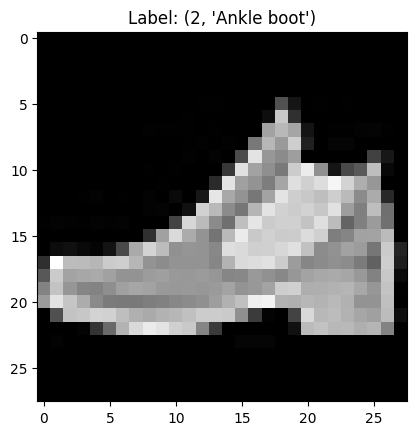

In [27]:
#Prints the shape of the train tensor
print(train.shape)

#Shows the image with corresponding label 

#Changes the label from number to clothing name for readability
switch = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
def switch_case(argument):
    return switch.get(argument)

#Change this to display the img_num image in the dataset. (0 indexed)
img_num = 1

#Gets the img_num row and all the column values for it
image_row = train.iloc[img_num, 1:]
#sets the label of the image for readability
label = switch_case(train.iloc[img_num, 0])

#Reshapes the row to a numpy array of size 28x28
image = np.array(image_row, dtype=np.uint8).reshape(28, 28)
#Displays the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {train.iloc[0, 0], label}')
plt.show()

In [28]:
#Displays the pixel values by row
image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          1,   0,   0,   0,   0,  81,  21,   0,   1,   0,   1,   0,   0,
          0,   0],
       [  

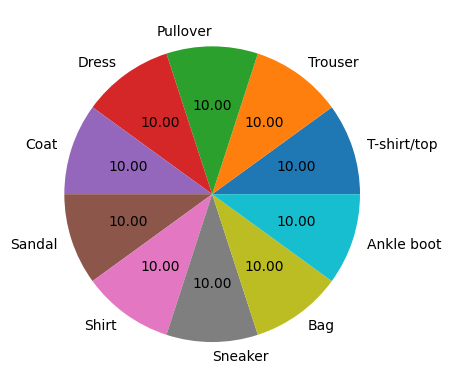

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

In [29]:
#Creates an array of the count of each type of item
count = train.iloc[0:, 0].value_counts().sort_index()

#Creates a piechart displaying the count of each category to ensure
#there is no data biases. 
label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
sizes=count.values
plt.pie(sizes, labels=label, autopct='%.2f' )
plt.show()

count

## Model

### Convolutional model

For our model, we use a combination of convolutional and linear layers, with ReLU inbetween layers. Linear layers multiply the input by a matrix A then add a bias B. 
Instead of going through the picture data pixel by pixel, convolutional layers instead examines it
through a kernel, the size of which can be chosen. Square (n x n) kernels are usually used. Each n x n part of the matrix representation
of the image is multplied with another n x n matrix of values. The number of unique positions that the kernel can be is smaller than
the image size, so the feature map obtained from the multiplication is smaller than the image. This means we will lose information each
time the picture is ran through a convolutional layer. Because pixels closer the the center of the image will be in more unique positions,
they will have a larger impact on the feature map. By adding padding around the image, we can ensure that all images in the original
picture will be represented in an equal amount of positions, and also that the resulting feature map does not result in information loss.
ReLU takes max(0, x) to introduce nonlinearities. 

In [30]:
class ConvolutionalModel(nn.Module):
    def __init__(self):
        super(ConvolutionalModel, self).__init__()
        self.layer_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.layer_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.layer_3 = nn.Conv2d(24, 10, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.layer_4 = nn.Linear(10 * 28 * 28, 128)
        self.layer_5 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.relu(self.layer_3(x))
        x = self.flatten(x)
        x = torch.relu(self.layer_4(x))
        x = self.layer_5(x)
        return x

    
model = ConvolutionalModel()

### Hyperparameters

We choose the criterion as multiclass cross entropy loss. We do not put any weights as the training set is balanced. CES works by 
taking the log of the softmax function then summing over all items in the batch and dividing by -1 * (total items)

In [46]:
num_epochs = 1
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training loop

We iterate over the images. Without getting into the details, the model calculates the gradient of the loss, and "steps" in the 
direction that has the greatest negative slope. The optimizer then updates the parameters  accordingly. 

In [50]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/1], Step [10/938], Loss: 0.2570
Epoch [1/1], Step [20/938], Loss: 0.2124
Epoch [1/1], Step [30/938], Loss: 0.1746
Epoch [1/1], Step [40/938], Loss: 0.1783
Epoch [1/1], Step [50/938], Loss: 0.1659
Epoch [1/1], Step [60/938], Loss: 0.3026
Epoch [1/1], Step [70/938], Loss: 0.2358
Epoch [1/1], Step [80/938], Loss: 0.2278
Epoch [1/1], Step [90/938], Loss: 0.1815
Epoch [1/1], Step [100/938], Loss: 0.1913
Epoch [1/1], Step [110/938], Loss: 0.2212
Epoch [1/1], Step [120/938], Loss: 0.1053
Epoch [1/1], Step [130/938], Loss: 0.2504
Epoch [1/1], Step [140/938], Loss: 0.5405
Epoch [1/1], Step [150/938], Loss: 0.1535
Epoch [1/1], Step [160/938], Loss: 0.2341
Epoch [1/1], Step [170/938], Loss: 0.1917
Epoch [1/1], Step [180/938], Loss: 0.2080
Epoch [1/1], Step [190/938], Loss: 0.1434
Epoch [1/1], Step [200/938], Loss: 0.2143
Epoch [1/1], Step [210/938], Loss: 0.2298
Epoch [1/1], Step [220/938], Loss: 0.1292
Epoch [1/1], Step [230/938], Loss: 0.1880
Epoch [1/1], Step [240/938], Loss: 0.3304
E

## Conclusion

In [54]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print (100*correct / total)

90.08


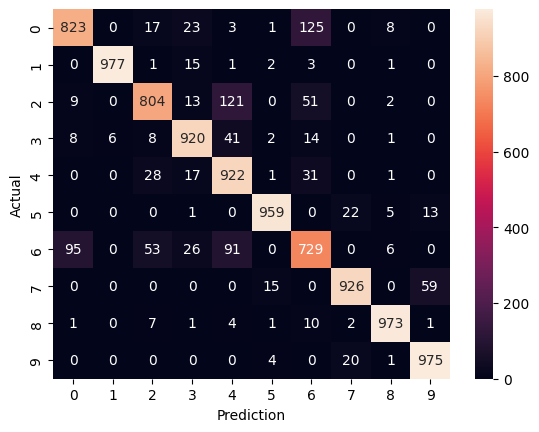

In [55]:

with torch.no_grad():
    y_predicted = model(x_test)
    y_predicted_cls = y_predicted.argmax(dim=1)

y_pred_np = y_predicted_cls.numpy().flatten()
y_test_np = y_test.numpy().flatten()
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()
